/Users/yannmclatchie/Desktop/kulprit/.venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_sigma, x2, x1, Intercept]


Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 14 seconds.
/Users/yannmclatchie/Desktop/kulprit/.venv/lib/python3.7/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


torch.Size([100, 3])


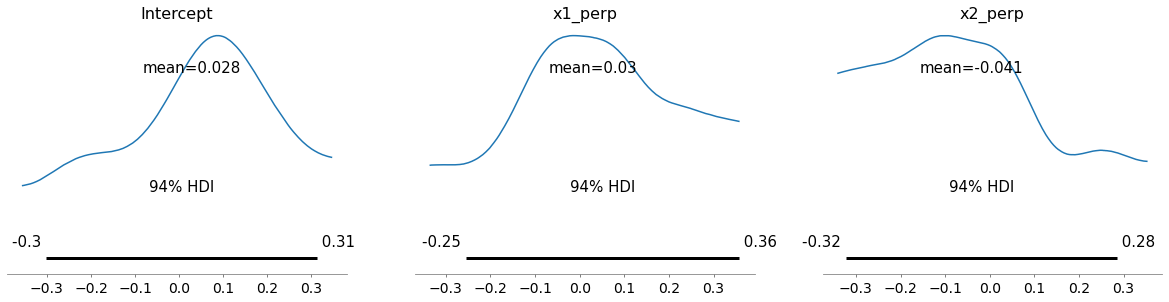

In [1]:
import pandas as pd
import numpy as np

import bambi as bmb
import kulprit as kpt

import arviz as az
import matplotlib.pyplot as plt

# define model data
data = pd.DataFrame({
    "y": np.random.normal(size=50),
    "g": np.random.choice(["Yes", "No"], size=50),
    "x1": np.random.normal(size=50),
    "x2": np.random.normal(size=50)
})
# define and fit model with MCMC
model = bmb.Model("y ~ x1 + x2", data, family="gaussian")
num_draws, num_chains = 50, 2
posterior = model.fit(draws=num_draws, chains=num_chains)
# build reference model object
ref_model = kpt.Projector(model, posterior)
# project the reference model to some parameter subset
params = ["x1", "x2"]
theta_perp = ref_model.project(params=params)
print(theta_perp.shape)
# visualise the projected model posterior
ref_model.plot_projection(params=params)

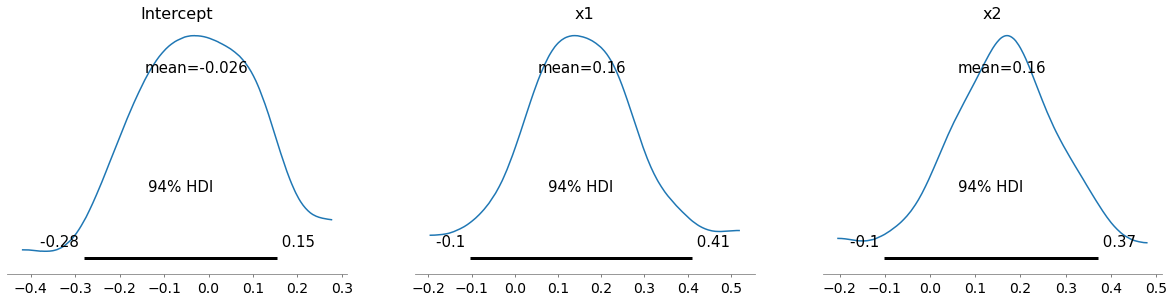

In [2]:
az.plot_posterior(posterior, var_names=["Intercept", "x1", "x2"])
plt.show()